<a href="https://colab.research.google.com/github/raulFuzita/cct_ai/blob/CA3/raul_macedo_fuzita_AI_DV_DP_ICA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [300]:
import pandas as pd
import numpy as np

df = pd.read_csv("https://raw.githubusercontent.com/raulFuzita/cct_ai/CA3/fire_station.csv")
df2 = pd.read_csv("https://raw.githubusercontent.com/raulFuzita/cct_ai/CA3/fire_station_v2.csv")
df_rooms = pd.read_csv("https://raw.githubusercontent.com/raulFuzita/cct_ai/CA3/rooms_location.csv")

In [ ]:
df

,officers,yes,no,office,no_office_adjacent
0,Phylis,NaN,Eva,1.0,NaN
1,Ann,NaN,Phylis; Eva,NaN,Phylis; Eva
2,Henry,Eva,Phylis; Ann; Bill; Mark; Bob,NaN,NaN
3,Eva,NaN,Mark; Bob; Bill,NaN,NaN
4,Bill,NaN,Phylis,NaN,NaN
5,Mark,Bob,NaN,NaN,NaN
6,Bob,Mark,NaN,NaN,NaN


In [ ]:
df2

,officers,yes,no,office,no_office_adjacent
0,Phylis,NaN,Eva; Henry; Bill,1.0,Ann
1,Ann,NaN,Phylis; Eva; Henry,NaN,Phylis; Eva
2,Henry,Eva,Phylis; Ann; Bill; Mark; Bob,NaN,NaN
3,Eva,Henry,Mark; Bob; Bill,NaN,Ann
4,Bill,NaN,Phylis; Henry; Eva,NaN,NaN
5,Mark,Bob,Henry; Eva,NaN,NaN
6,Bob,Mark,Henry; Eva,NaN,NaN


In [ ]:
df.to_dict()

{'no': {0: 'Eva',
  1: 'Phylis; Eva',
  2: 'Phylis; Ann; Bill; Mark; Bob',
  3: 'Mark; Bob; Bill',
  4: 'Phylis',
  5: nan,
  6: nan},
 'no_office_adjacent': {0: nan,
  1: 'Phylis; Eva',
  2: nan,
  3: nan,
  4: nan,
  5: nan,
  6: nan},
 'office': {0: 1.0, 1: nan, 2: nan, 3: nan, 4: nan, 5: nan, 6: nan},
 'officers': {0: 'Phylis',
  1: 'Ann',
  2: 'Henry',
  3: 'Eva',
  4: 'Bill',
  5: 'Mark',
  6: 'Bob'},
 'yes': {0: nan, 1: nan, 2: 'Eva', 3: nan, 4: nan, 5: 'Bob', 6: 'Mark'}}

In [301]:
df_rooms

,rooms,x,y,width,height
0,1,15,100,75,50
1,2,75,100,50,50
2,3,125,25,45,125
3,4,170,25,45,50


In [310]:
df_rooms.set_index('rooms').T.to_dict()

{1: {'height': 50, 'width': 75, 'x': 15, 'y': 100},
 2: {'height': 50, 'width': 50, 'x': 75, 'y': 100},
 3: {'height': 125, 'width': 45, 'x': 125, 'y': 25},
 4: {'height': 50, 'width': 45, 'x': 170, 'y': 25}}

In [ ]:
# csp.py
# From Classic Computer Science Problems in Python Chapter 3
# Copyright 2018 David Kopec
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
from typing import Generic, TypeVar, Dict, List, Optional
from abc import ABC, abstractmethod

V = TypeVar('V') # variable type
D = TypeVar('D') # domain type


# Base class for all constraints
class Constraint(Generic[V, D], ABC):
    # The variables that the constraint is between
    def __init__(self, variables: List[V]) -> None:
        self.variables = variables

    # Must be overridden by subclasses
    @abstractmethod
    def satisfied(self, assignment: Dict[V, D]) -> bool:
        ...


# A constraint satisfaction problem consists of variables of type V
# that have ranges of values known as domains of type D and constraints
# that determine whether a particular variable's domain selection is valid
class CSP(Generic[V, D]):
    def __init__(self, variables: List[V], domains: Dict[V, List[D]]) -> None:
        self.variables: List[V] = variables # variables to be constrained
        self.domains: Dict[V, List[D]] = domains # domain of each variable
        self.constraints: Dict[V, List[Constraint[V, D]]] = {}
        for variable in self.variables:
            self.constraints[variable] = []
            if variable not in self.domains:
                raise LookupError("Every variable should have a domain assigned to it.")

    def add_constraint(self, constraint: Constraint[V, D]) -> None:
        for variable in constraint.variables:
            if variable not in self.variables:
                raise LookupError("Variable in constraint not in CSP")
            else:
                self.constraints[variable].append(constraint)

    # Check if the value assignment is consistent by checking all constraints
    # for the given variable against it
    def consistent(self, variable: V, assignment: Dict[V, D]) -> bool:
        for constraint in self.constraints[variable]:
            if not constraint.satisfied(assignment):
                return False
        return True

    def backtracking_search(self, assignment: Dict[V, D] = {}) -> Optional[Dict[V, D]]:
        # assignment is complete if every variable is assigned (our base case)
        if len(assignment) == len(self.variables):
            return assignment

        # get all variables in the CSP but not in the assignment
        unassigned: List[V] = [v for v in self.variables if v not in assignment]

        # get the every possible domain value of the first unassigned variable
        first: V = unassigned[0]
        for value in self.domains[first]:
            local_assignment = assignment.copy()
            local_assignment[first] = value
            # if we're still consistent, we recurse (continue)
            if self.consistent(first, local_assignment):
                result: Optional[Dict[V, D]] = self.backtracking_search(local_assignment)
                # if we didn't find the result, we will end up backtracking
                if result is not None:
                    return result
        return None

In [ ]:
def split(col):
    if type(col) == str and ';' in col:
        return [item.strip() for item in col.split(';')]  
    else: 
        return [col] if col != None else col

def df_to_constraintdict(df):
    df = df.where(df.notnull(), None)
    tmp_dict = dict()
    for index, row in df.iterrows():

        tmp_dict[row['officers']] = {
            'yes': split(row['yes']),
            'no': split(row['no']),
            'office': row['office'],
            'no_office_adjacent': split(row['no_office_adjacent']),
        }
    return tmp_dict

In [ ]:
constraints = df_to_constraintdict(df)
constraints

{'Ann': {'no': ['Phylis', 'Eva'],
  'no_office_adjacent': ['Phylis', 'Eva'],
  'office': None,
  'yes': None},
 'Bill': {'no': ['Phylis'],
  'no_office_adjacent': None,
  'office': None,
  'yes': None},
 'Bob': {'no': None,
  'no_office_adjacent': None,
  'office': None,
  'yes': ['Mark']},
 'Eva': {'no': ['Mark', 'Bob', 'Bill'],
  'no_office_adjacent': None,
  'office': None,
  'yes': None},
 'Henry': {'no': ['Phylis', 'Ann', 'Bill', 'Mark', 'Bob'],
  'no_office_adjacent': None,
  'office': None,
  'yes': ['Eva']},
 'Mark': {'no': None,
  'no_office_adjacent': None,
  'office': None,
  'yes': ['Bob']},
 'Phylis': {'no': ['Eva'],
  'no_office_adjacent': None,
  'office': 1.0,
  'yes': None}}

In [ ]:
constraints2 = df_to_constraintdict(df)
constraints2

{'Ann': {'no': ['Phylis', 'Eva'],
  'no_office_adjacent': ['Phylis', 'Eva'],
  'office': None,
  'yes': None},
 'Bill': {'no': ['Phylis'],
  'no_office_adjacent': None,
  'office': None,
  'yes': None},
 'Bob': {'no': None,
  'no_office_adjacent': None,
  'office': None,
  'yes': ['Mark']},
 'Eva': {'no': ['Mark', 'Bob', 'Bill'],
  'no_office_adjacent': None,
  'office': None,
  'yes': None},
 'Henry': {'no': ['Phylis', 'Ann', 'Bill', 'Mark', 'Bob'],
  'no_office_adjacent': None,
  'office': None,
  'yes': ['Eva']},
 'Mark': {'no': None,
  'no_office_adjacent': None,
  'office': None,
  'yes': ['Bob']},
 'Phylis': {'no': ['Eva'],
  'no_office_adjacent': None,
  'office': 1.0,
  'yes': None}}

In [ ]:
from typing import Dict, List, Optional

class FireStation(Constraint[str, int]):
    def __init__(self, officers: List[str], constraints: Dict[str, object]) -> None:
        super().__init__(officers)
        self.officers: List[str] = officers
        self.constraints: Dict[str, object] = constraints

    def validate(self, offcr: str, cstrts: Dict[str, object], assgmt: Dict[int, str]) -> bool:
        if cstrts['no'] != None:
            for i in cstrts['no']:
                if (i in assgmt) and (offcr in assgmt):
                    print(offcr, cstrts, assgmt)
                    return assgmt[offcr] != assgmt[i]
        return True

    def satisfied(self, assignment: Dict[int, str]) -> bool:
        flag = True
        for i in self.officers:
           flag = self.validate(i, self.constraints[i], assignment)
           if flag: return flag
        return flag

In [ ]:
class MustBeAtOffice(Constraint[str, int]):
    def __init__(self, officer: str, officers: List[str], constraints: int) -> None:
        super().__init__(officers)
        self.officer: str = officer
        self.constraints: int = constraints

    def satisfied(self, assignment: Dict[int, str]) -> bool:
        if self.officer in assignment: 
            if assignment[self.officer] != self.constraints:
                return False
        return True

In [ ]:
class CannotWorkWith(Constraint[str, int]):
    def __init__(self, officer: str, officers: List[str], constraints: List[str]) -> None:
        super().__init__(officers)
        self.officer: str = officer
        self.constraints: List[str] = constraints

    def satisfied(self, assignment: Dict[int, str]) -> bool:
        for i in self.constraints:
            if self.officer in assignment and i in assignment:
                if assignment[self.officer] == assignment[i]:
                    return False
        return True

In [ ]:
class MustWorkWith(Constraint[str, int]):
    def __init__(self, officer: str, officers: List[str], constraints: List[str]) -> None:
        super().__init__(officers)
        self.officer: str = officer
        self.constraints: List[str] = constraints

    def satisfied(self, assignment: Dict[int, str]) -> bool:
        for i in self.constraints:
            if self.officer in assignment and i in assignment:
                if assignment[self.officer] != assignment[i]:
                    return False
        return True

In [ ]:
class 	NoAdjacentOffice(Constraint[str, int]):
    def __init__(self, officer: str, officers: List[str], constraints: List[str]) -> None:
        super().__init__(officers)
        self.officer: str = officer
        self.constraints: List[str] = constraints

    def satisfied(self, assignment: Dict[int, str]) -> bool:
        for i in self.constraints:
            if self.officer in assignment and i in assignment:
                diff = assignment[self.officer] - assignment[i]
                if diff >= -1 and diff <= 1:
                    return False
        return True

In [ ]:
if __name__ == "__main__":
    variables: List[str] = ['Phylis', 'Ann', 'Henry', 'Eva', 'Bill', 'Mark', 'Bob']
    domains: Dict[str, List[int]] = {}
    for variable in variables:
        domains[variable] = [1,2,3,4]

    csp: CSP[str, int] = CSP(variables, domains)
    csp.add_constraint(CannotWorkWith('Phylis', variables, ['Eva']))
    csp.add_constraint(MustBeAtOffice('Phylis', variables, 1))
    csp.add_constraint(NoAdjacentOffice('Phylis', variables, ['Ann']))

    csp.add_constraint(CannotWorkWith('Ann', variables, ['Phylis', 'Eva', 'Henry']))
    csp.add_constraint(NoAdjacentOffice('Ann', variables, ['Phylis', 'Eva']))

    csp.add_constraint(CannotWorkWith('Henry', variables, ['Phylis', 'Ann', 'Bill', 'Mark', 'Bob']))
    csp.add_constraint(MustWorkWith('Henry', variables, ['Eva']))

    csp.add_constraint(CannotWorkWith('Eva', variables, ['Mark', 'Bob', 'Bill']))
    csp.add_constraint(MustWorkWith('Eva', variables, ['Henry']))
    csp.add_constraint(NoAdjacentOffice('Eva', variables, ['Ann']))

    csp.add_constraint(CannotWorkWith('Bill', variables, ['Phylis', 'Henry', 'Eva']))

    csp.add_constraint(CannotWorkWith('Mark', variables, ['Henry', 'Eva']))
    csp.add_constraint(MustWorkWith('Mark', variables, ['Bob']))
    csp.add_constraint(CannotWorkWith('Bob', variables, ['Henry', 'Eva']))
    csp.add_constraint(MustWorkWith('Bob', variables, ['Mark']))
    solution: Optional[Dict[str, int]] = csp.backtracking_search()

    print("No solution found!")  if solution is None else print(solution)

{'Phylis': 1, 'Ann': 4, 'Henry': 2, 'Eva': 2, 'Bill': 3, 'Mark': 1, 'Bob': 1}


In [ ]:
# {'Phylis': 1, 'Ann': 4, 'Henry': 2, 'Eva': 2, 'Bill': 3, 'Mark': 1, 'Bob': 1}

In [313]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

class RoomsGraph:

    def __init__(self, rooms: dict=dict(), components: dict=dict(), figsize: tuple=(12, 8)) -> None:
        self.plt = plt
        self.plt.rcParams["figure.figsize"]=figsize
        fig, ax = self.plt.subplots()
        self.fig = fig
        self.ax = ax
        self.setGrid(True)
        self.addRooms(rooms)
        self.addComponents(components)
        self.setComponentSize(14)
        self.setTite('Rooms\n')
        self.colors = ['blue', 'orange', 'green', 'red', 'purple', 
                       'brown', 'pink', 'gray', 'olive', 'cyan']

    def setGrid(self, flag: bool):
        self.ax.grid(flag)
        return self

    def setTite(self, title: str, fontsize: int=20):
        self.ax.set_title(title, fontsize=fontsize)
        return self

    def setXLabel(self, label: str, labelsize: int=20):
        self.plt.rc('axes', labelsize=labelsize)
        self.ax.set_xlabel(label)
        return self

    def setYLabel(self, label: str, labelsize: int=20):
        self.plt.rc('axes', labelsize=labelsize)
        self.ax.set_ylabel(label)
        return self

    def addRooms(self, rooms: dict):
        self.rooms = rooms
        return self

    def addComponents(self, components: dict):
        self.components = components
        return self

    def setComponentSize(self, fontsize: int):
        self.compSize = fontsize
        return self

    def _yieldComponents(self) -> None:
        roomfreq = dict()
        for i in self.components:
            num = self.components[i]
            roomfreq[num] = roomfreq[num]+1 if num in roomfreq else 1
            x = (self.rooms[num]['x']+5)
            y = (self.rooms[num]['y']+self.rooms[num]['height'])
            y -= (roomfreq[num] * 6)
            self.ax.annotate(i, (x, y), fontsize=self.compSize)

    def _yieldRooms(self) -> None:
        count = 0
        for i in self.rooms:
            room = self.rooms[i]
            self.ax.broken_barh(
                [(room['x'], room['width'])], 
                (room['y'], room['height']), 
                facecolors='tab:'+self.colors[count])
            count+=1

    def _yieldLegend(self) -> None:
        legends = list()
        for i in range(len(self.rooms)):
            legends.append(mpatches.Patch(color=self.colors[i], label=(i+1)))
        plt.legend(handles=legends)

    def show(self) -> None:
        self._yieldRooms()
        self._yieldLegend()
        self._yieldComponents()
        self.plt.show()

In [278]:
rooms = {
    '1': {'x': 15, 'width': 75, 'y': 100, 'height': 50},
    '2': {'x': 75, 'width': 50, 'y': 100, 'height': 50},
    '3': {'x': 125, 'width': 45, 'y': 25, 'height': 125},
    '4': {'x': 170, 'width': 45, 'y': 25, 'height': 50}
}

In [315]:
rooms = df_rooms.set_index('rooms').T.to_dict()

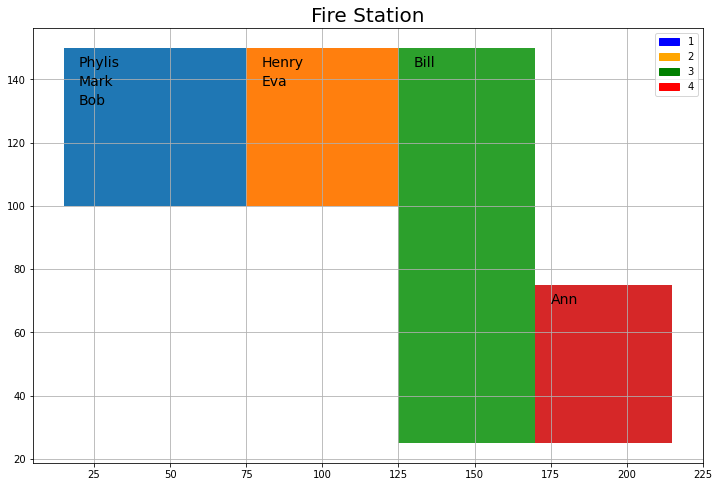

In [319]:
rg = RoomsGraph(rooms)
# {'Phylis': 1, 'Ann': 4, 'Henry': 2, 'Eva': 2, 'Bill': 3, 'Mark': 1, 'Bob': 1}
rg.setTite('Fire Station').addComponents({'Phylis': 1, 'Ann': 4, 'Henry': 2, 'Eva': 2, 'Bill': 3, 'Mark': 1, 'Bob': 1})
rg.show()

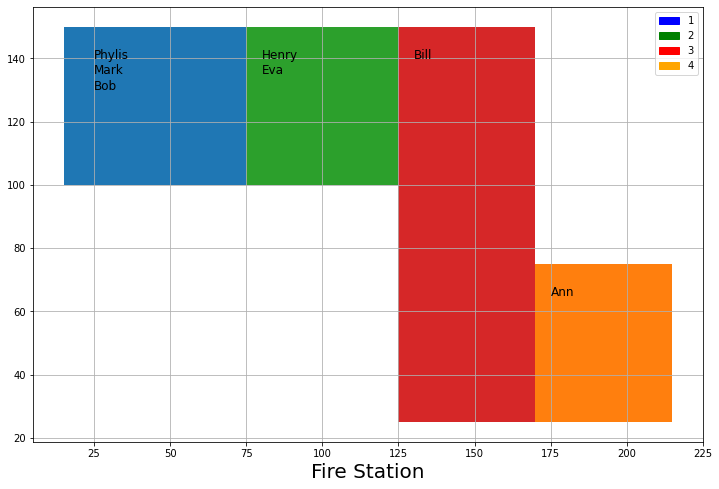

In [203]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"]=(12, 8)
plt.rc('axes', labelsize=20)
fig, ax = plt.subplots()
ax.broken_barh([(15, 75)], (100, 50), facecolors='tab:blue')
ax.broken_barh([(75, 50)], (100, 50), facecolors='tab:green')
ax.broken_barh([(125, 45)], (25, 125), facecolors='tab:red')
ax.broken_barh([(170, 45)], (25, 50), facecolors='tab:orange')

ax.set_xlabel('Fire Station')

ax.annotate('Phylis', (25, 140), fontsize=12)
ax.annotate('Ann', (175, 65), fontsize=12)
ax.annotate('Henry', (80, 140), fontsize=12)
ax.annotate('Eva', (80, 135), fontsize=12)
ax.annotate('Bill', (130, 140), fontsize=12)
ax.annotate('Mark', (25, 135), fontsize=12)
ax.annotate('Bob', (25, 130), fontsize=12)

plt.legend(handles=[
    mpatches.Patch(color='blue', label='1'),
    mpatches.Patch(color='green', label='2'),
    mpatches.Patch(color='red', label='3'),
    mpatches.Patch(color='orange', label='4')
])

ax.grid(True)
plt.show()